## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [ ]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random
import os

import sinogap_module_long as sg




### <font style="color:lightblue">Redefine</font>

In [ ]:
sg.plt.rcParams['figure.dpi']=223
sg.plt.rcParams['axes.spines.left'] = False
sg.plt.rcParams['axes.spines.right'] = False
sg.plt.rcParams['axes.spines.top'] = False
sg.plt.rcParams['axes.spines.bottom'] = False




### <font style="color:lightblue">Configs</font>

In [27]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 0
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**8
    ,batchSplit = 2**0
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 1e-3
    ,learningRateG = 1e-3
    ,dataDir = 'data'
    ,num_workers=16
)

sg.DCfg = sg.DCfgClass(2)

#os.environ["CTAS_MMAP_PATH"] = "/mnt/ssdData/"


### <font style="color:lightblue">Raw Read</font>

In [4]:
sg.trainSet = sg.createDataSet(sg.TCfg.dataDir, sg.listOfTrainData, exclusive=False)
sg.testSet = sg.createDataSet(sg.TCfg.dataDir+"/test", sg.listOfTestData, exclusive=True)

Done
Loading train set 2 of 17: data/23574.8965435L.Eiger.32kev_sft ... Done
Loading train set 3 of 17: data/19022g.11-EggLard ... Done
Loading train set 4 of 17: data/18692b.MinceO ... Done
Loading train set 5 of 17: data/23574.8965435L.Eiger.32kev_org ... Done
Loading train set 6 of 17: data/19736b.09_Feb.4176862R_Eig_Threshold-4keV ... Done
Loading train set 7 of 17: data/20982b.04_774784R ... Done
Loading train set 8 of 17: data/18515.Lamb1_Eiger_7m_45keV_360Scan ... Done
Loading train set 9 of 17: data/19736c.8733147R_Eig_Threshold-8keV.SAMPLE_Y1 ... Done
Loading train set 10 of 17: data/18692b_input_PhantomM ... Done
Loading train set 11 of 17: data/21836b.2024-08-15-mastectomies.4201381L.35kev.20Hz ... Done
Loading train set 12 of 17: data/23574h.9230799R.35kev ... Done
Loading train set 13 of 17: data/18515.Lamb4_Excised_Eiger_7m_30keV_360Scan.Y1 ... Done
Loading train set 14 of 17: data/18648.B_Edist.80keV_0m_Eig_Neoprene.Y2 ... Done
Loading train set 15 of 17: data/19932.10_8

### <font style="color:lightblue">Show</font>

(3, 825, 259) 45846 (3600, 80)
6.401e-01, 3.585e-01, 9.379e-02, 1.020e+00


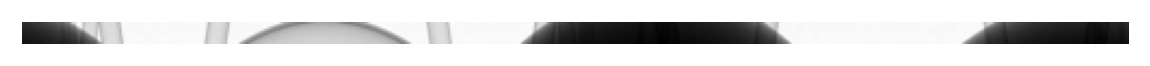

In [7]:
sg.refImages, sg.refNoises, sg.refBoxes = sg.createReferences(sg.testSet, 0)
sg.showMe(sg.testSet)


## <font style="color:lightblue">Models</font>

### Generator 2pix

In [16]:
class Generator2(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator2, self).__init__(2, batchNorm=True)
        self.amplitude = 4 # found by training to optimize it (3.3)
        self.encoders =  nn.ModuleList([
            self.encblock(  1/self.baseChannels,
                               1, 3, padding=1, norm=False),
            self.encblock(  1, 1, 3, padding=(1,0)), self.encblock(  1, 2, 3, stride=(2,1), padding=(1,1)),
            self.encblock(  2, 2, 3, padding=(1,0)), self.encblock(  2, 4, 3, stride=(2,1), padding=(1,1)),
            self.encblock(  4, 4, 3, padding=(1,0)), self.encblock(  4, 8, 3, stride=(2,1), padding=(1,0)),
            #self.encblock(  8, 8, 3, padding=(1,0)), self.encblock(  8,16, 3, stride=(2,1), padding=(1,1)),
            ])
        self.fcLink = self.createFClink()
        self.decoders = nn.ModuleList([
            #self.decblock(32, 8, 3, stride=(2,1), outputPadding=(1,0), padding=(1,1)), self.decblock(16, 8, 3, padding=(1,0)),
            self.decblock(16, 4, 3, stride=(2,1), outputPadding=(1,0), padding=(1,0)), self.decblock( 8, 4, 3, padding=(1,0)),
            self.decblock( 8, 2, 3, stride=(2,1), outputPadding=(1,0), padding=(1,1)), self.decblock( 4, 2, 3, padding=(1,0)),
            self.decblock( 4, 1, 3, stride=(2,1), outputPadding=(1,0), padding=(1,1)), self.decblock( 2, 1, 3, padding=(1,0)),
            self.decblock( 2, 1, 3, padding=1, norm=False),
            ])
        self.lastTouch = self.createLastTouch()
        #sg.load_model(self, model_path="model_3_gen.pt" )


generator2 = Generator2()
generator2 = generator2.to(sg.TCfg.device)
#generator2 = generator2.requires_grad_(False)
generator2 = generator2.eval()
sg.lowResGenerators[2] = generator2

model_summary = summary(generator2, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
print(model_summary)




Layer (type:depth-idx)                   Output Shape              Param #
Generator2                               [1, 1, 512, 2]            --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 4, 512, 10]           --
│    │    └─Conv2d: 3-1                  [1, 4, 512, 10]           40
│    │    └─LeakyReLU: 3-2               [1, 4, 512, 10]           --
│    └─Sequential: 2-2                   [1, 4, 512, 8]            --
│    │    └─Conv2d: 3-3                  [1, 4, 512, 8]            144
│    │    └─BatchNorm2d: 3-4             [1, 4, 512, 8]            8
│    │    └─LeakyReLU: 3-5               [1, 4, 512, 8]            --
│    └─Sequential: 2-3                   [1, 8, 256, 8]            --
│    │    └─Conv2d: 3-6                  [1, 8, 256, 8]            288
│    │    └─BatchNorm2d: 3-7             [1, 8, 256, 8]            16
│    │    └─LeakyReLU: 3-8               [1, 8, 256, 8]            --
│    └─Sequent

### <font style="color:lightblue">Generator</font>

In [17]:
sg.generator = sg.lowResGenerators[sg.DCfg.gapW]
sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
print(sg.refImages.shape, sg.refImages[[0],...].shape)
print(model_summary)


torch.Size([5, 1, 512, 10]) torch.Size([1, 1, 512, 10])
Layer (type:depth-idx)                   Output Shape              Param #
Generator2                               [1, 1, 512, 2]            --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 4, 512, 10]           --
│    │    └─Conv2d: 3-1                  [1, 4, 512, 10]           40
│    │    └─LeakyReLU: 3-2               [1, 4, 512, 10]           --
│    └─Sequential: 2-2                   [1, 4, 512, 8]            --
│    │    └─Conv2d: 3-3                  [1, 4, 512, 8]            144
│    │    └─BatchNorm2d: 3-4             [1, 4, 512, 8]            8
│    │    └─LeakyReLU: 3-5               [1, 4, 512, 8]            --
│    └─Sequential: 2-3                   [1, 8, 256, 8]            --
│    │    └─Conv2d: 3-6                  [1, 8, 256, 8]            288
│    │    └─BatchNorm2d: 3-7             [1, 8, 256, 8]            16
│    │    └─LeakyReLU: 3-8  

### <font style="color:lightblue">Discriminator</font>

In [18]:

class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.param = nn.Parameter(torch.zeros(1))
    def forward(self, images):
        return torch.zeros((images.shape[0],1), device=sg.TCfg.device)

sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)



Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    1
Total params: 1
Trainable params: 1
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.10


## <font style="color:lightblue">Norms</font>

In [20]:
#sg.dataLoader = sg.createDataLoader(sg.trainSet, shuffle=True, num_workers=16)
sg.testLoader = sg.createDataLoader(sg.testSet, shuffle=False)

#_ = sg.summarizeMe(sg.testLoader, True)
#_ = sg.summarizeMe(sg.testLoader, False)
#_ = sg.summarizeMe(sg.dataLoader, True)
#_ = sg.summarizeMe(sg.dataLoader, False)
#sg.displayImages()

### no prenorm

sg.metrices = {
    'Adv'    : sg.Metrics(sg.loss_Adv_Gen, 0.000e+00, 0),
    'MSE'    : sg.Metrics(sg.loss_MSE,     2.189e-01, 1),
    'MSEN'   : sg.Metrics(sg.loss_MSEN,    1.684e+01, 0),
    'L1L'    : sg.Metrics(sg.loss_L1L,     4.609e+00, 0),
    'L1LN'   : sg.Metrics(sg.loss_L1LN,    4.524e+01, 0),
    'SSIM'   : sg.Metrics(sg.loss_SSIM,    5.143e-04, 0),
    'MSSSIM' : sg.Metrics(sg.loss_MSSSIM,  6.038e-06, 0),
}
#
#sg.metricesTrain = {
#    'Adv'    : sg.Metrics(sg.loss_Adv_Gen, 0.000e+00, 0),
#    'MSE'    : sg.Metrics(sg.loss_MSE,     5.836e-01, 1),
#    'MSEN'   : sg.Metrics(sg.loss_MSEN,    9.134e+01, 1),
#    'L1L'    : sg.Metrics(sg.loss_L1L,     9.741e+00, 1),
#    'L1LN'   : sg.Metrics(sg.loss_L1LN,    1.727e+02, 1),
#    'SSIM'   : sg.Metrics(sg.loss_SSIM,    8.716e-04, 1),
#    'MSSSIM' : sg.Metrics(sg.loss_MSSSIM,  4.351e-02, 1),
#}


## <font style="color:lightblue">Restore checkpoint</font>

In [24]:

sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1)
#sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1)
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint()#savedCheckPoint+".pth")
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)



sg.scheduler_G.gamma = 1-0.01
#sg.scheduler_D.gamma = 1-0.005
sg.optimizer_G.step()
torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 1).step()
#sg.optimizer_D.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_D, lambda epoch: 0.05).step()

print(f"Initial LR : G {sg.scheduler_G.get_last_lr()[0]:.3e} ({sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG:.4f})")
                  #f" D {sg.scheduler_D.get_last_lr()[0]:.3e} ({sg.scheduler_D.get_last_lr()[0]/sg.TCfg.learningRateD:.4f}), Epoch {sg.epoch} {sg.imer}")


Initial LR : G 1.000e-03 (1.0000)


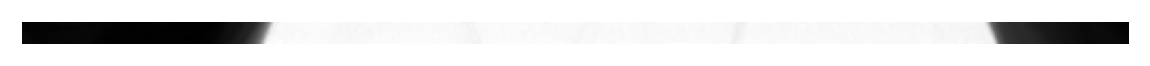

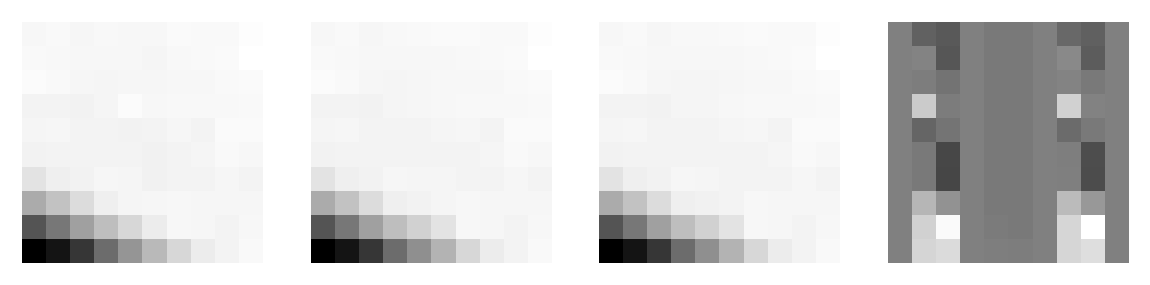

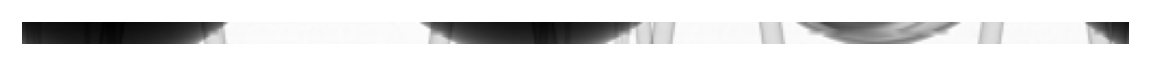

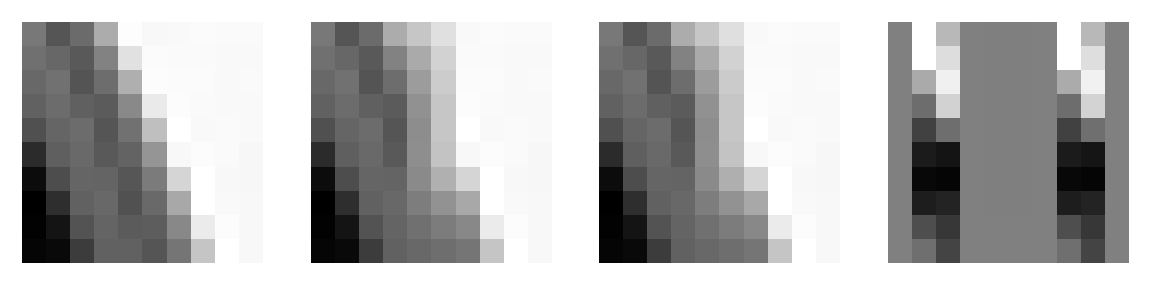

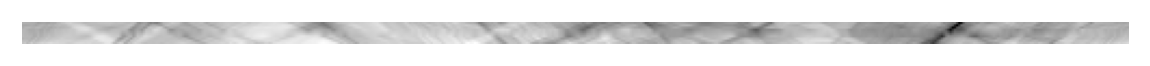

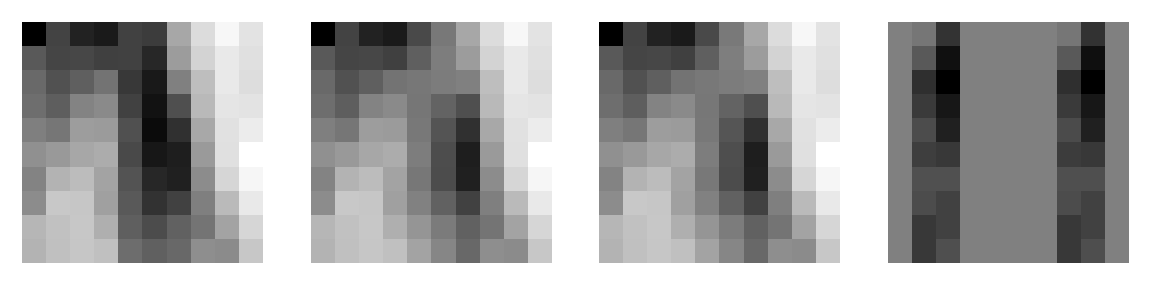

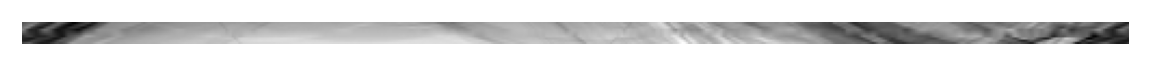

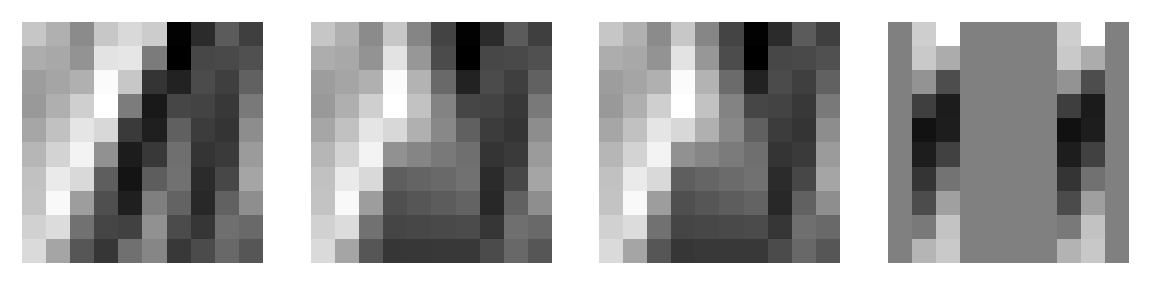

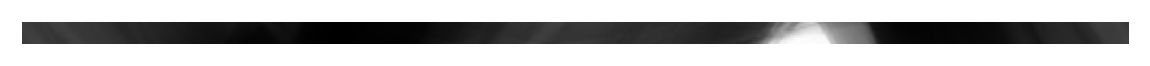

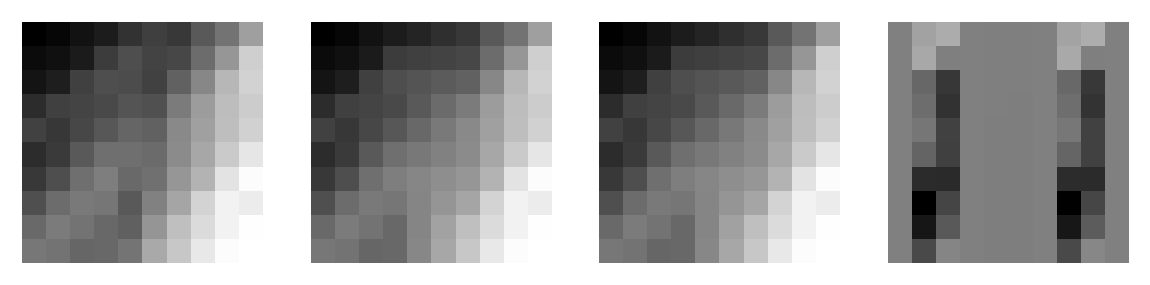

In [25]:
sg.displayImages()
#_ = sg.summarizeMe(sg.testLoader, False)

## <font style="color:lightblue">Execute</font>

Epoch: 1 (0).  Images: 20224. DIS: 0.000e+00, GEN: 5.718e-01. Probs: True 0.000e+00, Fake 0.000e+00.
Individual losses: Adv: 1.000e+00  MSE: 5.718e-01  MSEN: 4.206e+00  L1L: 1.326e+00  L1LN: 3.250e+00  SSIM: 9.579e-01  MSSSIM: 1.222e+00 



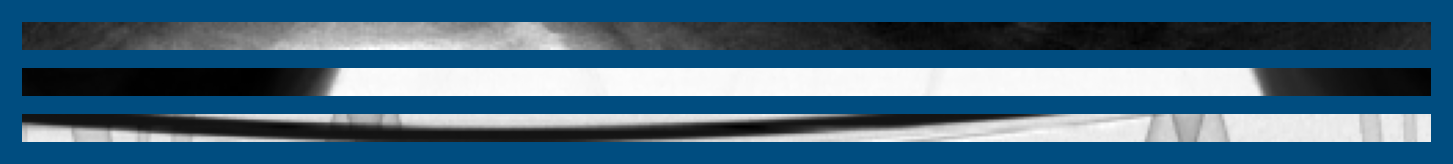

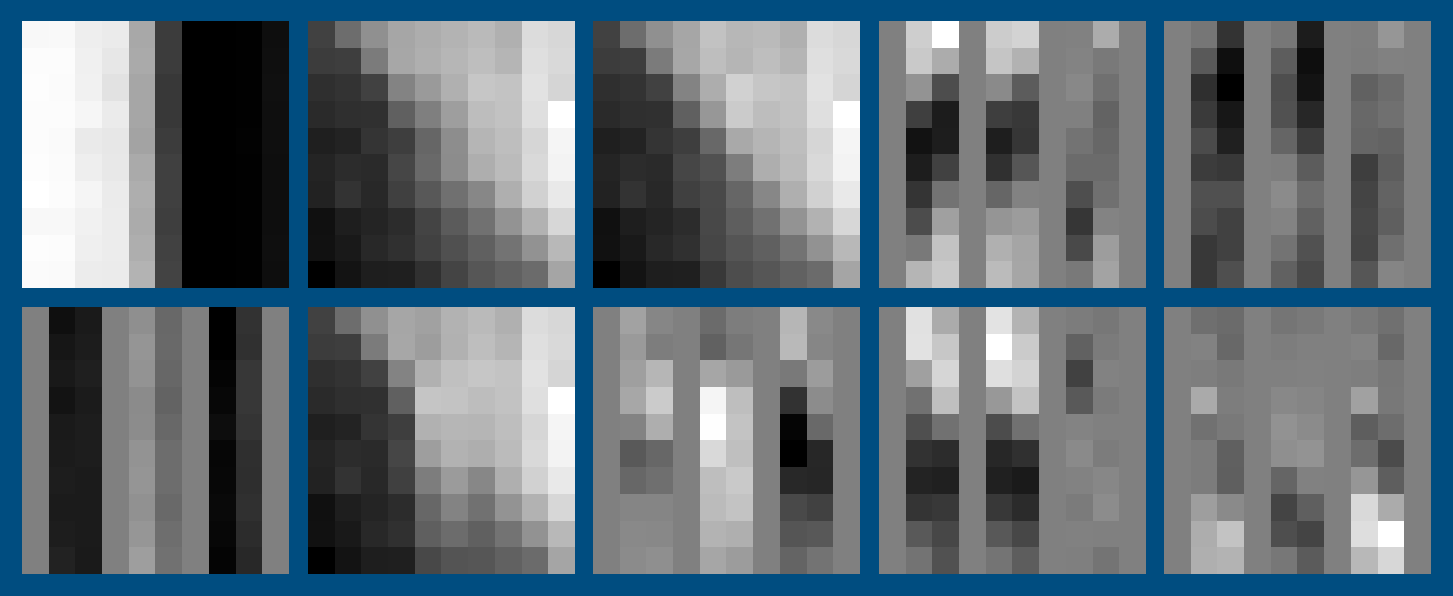

  8%|▊         | 5166/66407 [1:19:59<9:55:34,  1.71it/s] 

In [ ]:


sg.scheduler_G.gamma = 1-0.005
def my_beforeReport(sglocals) :
    message = ""

    message += "G" + sg.adjustScheduler(sg.scheduler_G, sg.TCfg.learningRateG, 0.0001)
    sg.writer.add_scalars("Aux", {'LrnRate': sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG}, sg.imer)

    #for metrics in ('L1L','SSIM','MSSSIM') :
    #    sg.metrices[metrics].weight = max(0, sg.metrices[metrics].weight - 0.005)
    #    message += f"{metrics} weight: {sg.metrices[metrics].weight}. "
    #    sg.writer.add_scalars("Aux", {metrics: sg.metrices[metrics].weight}, sg.imer)

    print(message)
    return
#sg.beforeReport = my_beforeReport

def my_beforeEachEpoch(sglocals) :
    sg.TCfg.batchSize = min(2**12, sg.TCfg.batchSize * 2)
    sg.TCfg.batchSplit = max(2**0, int(sg.TCfg.batchSize / 2**9))
    sg.writer.add_scalars("Aux", {'Batch size': math.log(2**12,2)}, sg.imer)
    print(f"Batch size: {sg.TCfg.batchSize}, split: {sg.TCfg.batchSplit}", )
    return
#sg.beforeEachEpoch = my_beforeEachEpoch

try :
    sg.train(savedCheckPoint)
except :
    #del sg.dataLoader
    #del sg.testLoader
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.epoch -= 1
    raise



# loss MSE raw, BS=2**8, LR=1e-3
#27 LR -> 1e-4
#44 BS -> 2**12
#63 BS => 2**8; loss MSE => MSSSIM

## <font style="color:lightblue">Post</font>

In [ ]:
sg.saveCheckPoint(savedCheckPoint+".pth",
                           sg.epoch+1, sg.imer, sg.minGEpoch, sg.minGLoss,
                           sg.generator, sg.discriminator,
                           sg.optimizer_G, sg.optimizer_D)


In [ ]:
for key in sg.resAcc.metrices.keys() :
    if sg.metrices[key].norm > 0 :
        sg.writer.add_scalars("Metrices_per_epoch", {key : sg.resAcc.metrices[key],}, sg.epoch )

resTest = sg.summarizeMe(sg.testLoader, False)
resTest *= 1/resTest.nofIm
sg.writer.add_scalars("Losses epoch test",
                   {'Dis': resTest.lossD
                   ,'Gen': resTest.lossG
                   #,'Adv' : resTest.metrices['Adv']
                   }, sg.epoch )
for key in resTest.metrices.keys() :
    if sg.metrices[key].norm > 0 :
        sg.writer.add_scalars("Metrices epoch test", {key : resTest.metrices[key],}, sg.epoch )
sg.writer.add_scalars("Probs epoch test",
                   {'Ref':resTest.predReal
                   ,'Gen':resTest.predFake
                   #,'Pre':trainRes.predGen
                   }, sg.epoch )





In [ ]:
item = sg.testSet.__getitem__(11142)
print(item['coord'], item['index'], item['orgSh'])
#image = item['image'].squeeze().transpose(0,1)
sg.displayImages(item['image'].to(sg.TCfg.device))



### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()